In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl

sys.path.append('../../src')
sys.path.append('../../src/vae/models')
sys.path.append('../../src/dsets/cosmology')
from dset import get_dataloader
from losses import _reconstruction_loss
from viz import viz_im_r, cshow, viz_filters
from sim_cosmology import p, load_dataloader_and_pretrained_model
from captum.attr import *

# trim modules
sys.path.append('../../lib/trim')
from trim import TrimModel

# wt modules
from wavelet_transform import Wavelet_Transform, DTCWT_Mask, tuple_Attributer, create_images_high_attrs, compute_tuple_dim
from wavelet_transform import Wavelet_Transform_from_Scratch
import pywt

## load data and model

In [2]:
# get dataloader and model
train_loader, model = load_dataloader_and_pretrained_model(p)

## wavelet

In [16]:
# pywt.wavelist()
# wavelet transform
wt = Wavelet_Transform_from_Scratch(init_wavelet='bior2.2')

# prepend transformation onto network
mt = TrimModel(model, wt.ifm)

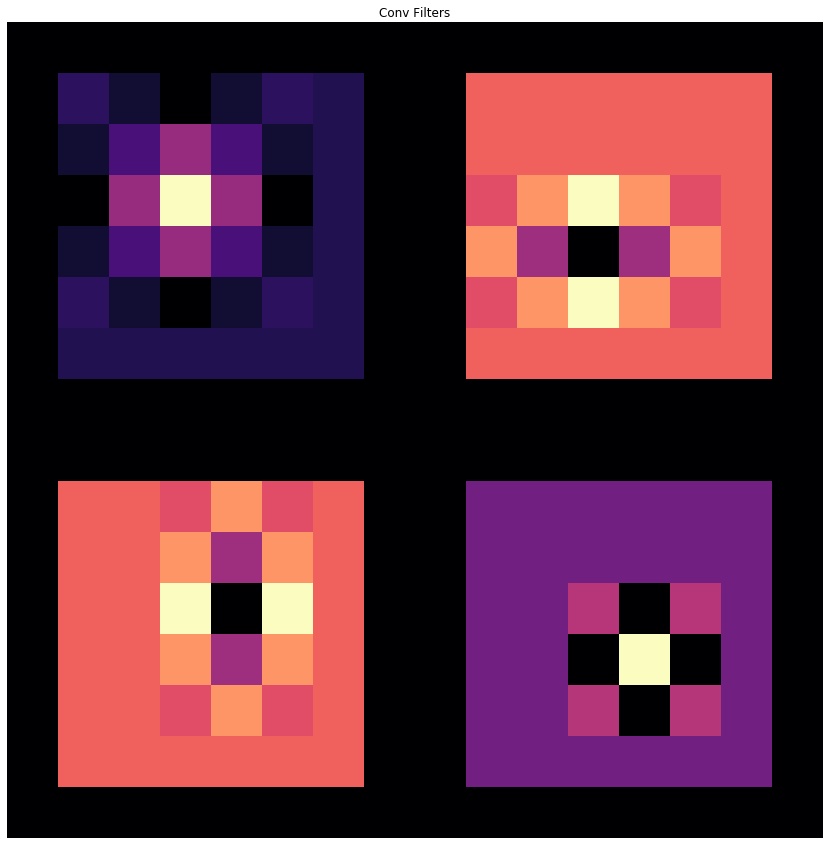

In [17]:
viz_filters(wt.filters, n_row=2, n_col=2, resize_fac=1, normalize=True, title='Conv Filters')

In [14]:
# pywt.wavelist()
# wavelet transform
wt = Wavelet_Transform_from_Scratch(init_wavelet='db3')

# prepend transformation onto network
mt = TrimModel(model, wt.ifm)

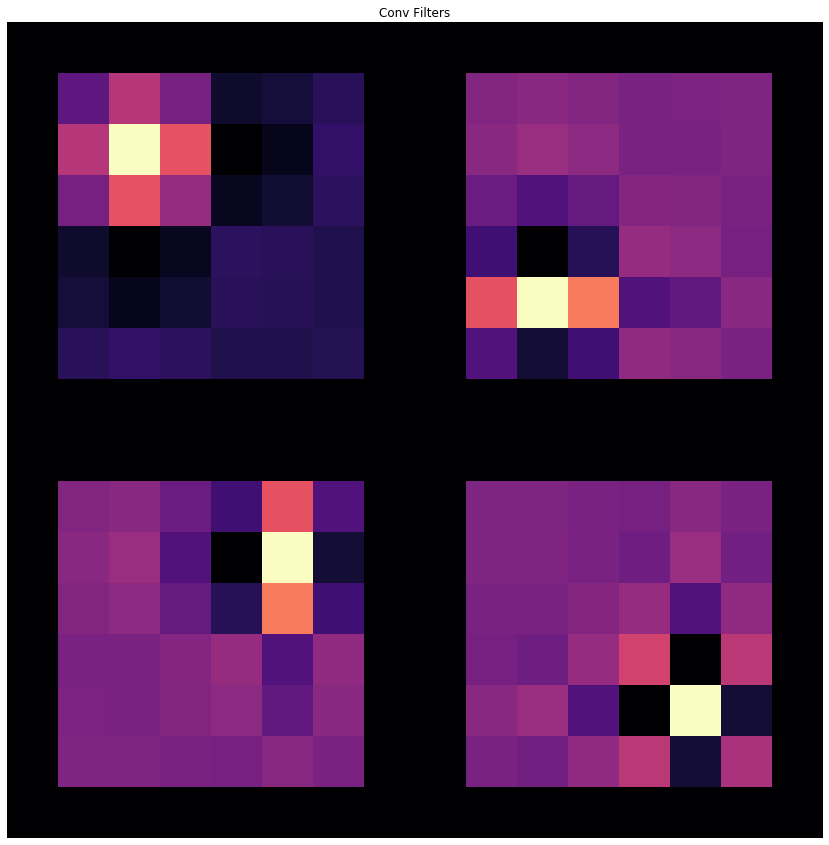

In [15]:
viz_filters(wt.filters, n_row=2, n_col=2, resize_fac=1, normalize=True, title='Conv Filters')

In [18]:
# class Wavelet_Transform(nn.Module):
#     def __init__(self, init_wavelet='bior2.2', requires_grad=True, device='cuda'): 
#         super(Wavelet_Transform, self).__init__()        
#         # initialize        
#         w = pywt.Wavelet(init_wavelet)
#         dec_hi = torch.tensor(w.dec_hi[::-1])
#         dec_lo = torch.tensor(w.dec_lo[::-1])
#         rec_hi = torch.tensor(w.rec_hi)
#         rec_lo = torch.tensor(w.rec_lo)        
#         self.dec_hi = nn.Parameter(dec_hi.to(device), requires_grad=requires_grad)
#         self.dec_lo = nn.Parameter(dec_lo.to(device), requires_grad=requires_grad)
#         self.rec_hi = nn.Parameter(rec_hi.to(device), requires_grad=requires_grad)
#         self.rec_lo = nn.Parameter(rec_lo.to(device), requires_grad=requires_grad)
        
#         self.filters = torch.stack([self.dec_lo.unsqueeze(0)*self.dec_lo.unsqueeze(1),
#                                     self.dec_lo.unsqueeze(0)*self.dec_hi.unsqueeze(1),
#                                     self.dec_hi.unsqueeze(0)*self.dec_lo.unsqueeze(1),
#                                     self.dec_hi.unsqueeze(0)*self.dec_hi.unsqueeze(1)], dim=0)  
        
#         self.inv_filters = torch.stack([self.rec_lo.unsqueeze(0)*self.rec_lo.unsqueeze(1),
#                                         self.rec_lo.unsqueeze(0)*self.rec_hi.unsqueeze(1),
#                                         self.rec_hi.unsqueeze(0)*self.rec_lo.unsqueeze(1),
#                                         self.rec_hi.unsqueeze(0)*self.rec_hi.unsqueeze(1)], dim=0)        
    
#     def xfm(self, x, levels=5):
#         # wavelet transform
#         h = x.size(2)
#         w = x.size(3)
#         x_t = F.conv2d(x, self.filters[:,None], stride=2, padding=2) # only works for filter of size 6
#         res = x_t.clone()
#         if levels > 1:
#             res = self.xfm(res[:,:1], levels=levels-1)
#             x_t[:,:1] = res
#         x_t = x_t.reshape(-1,2,h//2,w//2).transpose(1,2).contiguous().reshape(-1,1,h,w)
#         return x_t
    
#     def ifm(self, x, levels=5):
#         # inverse wavelet transform
#         h = x.size(2)
#         w = x.size(3)
#         res = x.reshape(-1,h//2,2,w//2).transpose(1,2).contiguous().reshape(-1,4,h//2,w//2).clone()
#         if levels > 1:
#             res[:,:1] = self.ifm(res[:,:1], levels=levels-1)
#         res = F.conv_transpose2d(res, self.inv_filters[:,None], stride=2)
#         res = res[:,:,2:-2,2:-2]
#         return res
    

# class Mask_WaveCoeffs(nn.Module):
#     def __init__(self, img_size=256, requires_grad=True, device='cuda'):
#         super(Mask_WaveCoeffs, self).__init__()
#         self.img_size = img_size
#         mask_init = torch.ones(img_size,img_size)
#         self.mask = nn.Parameter(mask_init.to(device), requires_grad=requires_grad)
        
#     def forward(self, x):
#         return torch.mul(x, self.mask)
    
#     def projection(self):
#         self.mask.data = torch.clamp(self.mask.data, 0, 1)    